In [1]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy


# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [2]:

path = ("datasets")

print("Path to dataset files:", path)

Path to dataset files: datasets


In [3]:
classes=[]
filename='datasets'
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [4]:
train_path='datasets/Training/'
test_path='datasets/Testing/'

In [5]:
img_list=[]
label_list=[]
for label in classes:
    for img_file in os.listdir(train_path+label):
        img_list.append(train_path+label+'/'+img_file)
        label_list.append(label)

In [6]:
train_data = pd.DataFrame({'Image':img_list,'Label':label_list})
train_data

,Image,Label
0,datasets/Training/glioma/Tr-glTr_0000.jpg,glioma
1,datasets/Training/glioma/Tr-glTr_0001.jpg,glioma
2,datasets/Training/glioma/Tr-glTr_0002.jpg,glioma
3,datasets/Training/glioma/Tr-glTr_0003.jpg,glioma
4,datasets/Training/glioma/Tr-glTr_0004.jpg,glioma
...,...,...
5707,datasets/Training/pituitary/Tr-pi_1452.jpg,pituitary
5708,datasets/Training/pituitary/Tr-pi_1453.jpg,pituitary
5709,datasets/Training/pituitary/Tr-pi_1454.jpg,pituitary
5710,datasets/Training/pituitary/Tr-pi_1455.jpg,pituitary


In [7]:
img_list=[]
label_list=[]
for label in classes:
    for img_file in os.listdir(test_path+label):
        img_list.append(test_path+label+'/'+img_file)
        label_list.append(label)

In [8]:
test_data = pd.DataFrame({'Image':img_list,'Label':label_list})
test_data

,Image,Label
0,datasets/Testing/glioma/Te-glTr_0000.jpg,glioma
1,datasets/Testing/glioma/Te-glTr_0001.jpg,glioma
2,datasets/Testing/glioma/Te-glTr_0002.jpg,glioma
3,datasets/Testing/glioma/Te-glTr_0003.jpg,glioma
4,datasets/Testing/glioma/Te-glTr_0004.jpg,glioma
...,...,...
1306,datasets/Testing/pituitary/Te-pi_0295.jpg,pituitary
1307,datasets/Testing/pituitary/Te-pi_0296.jpg,pituitary
1308,datasets/Testing/pituitary/Te-pi_0297.jpg,pituitary
1309,datasets/Testing/pituitary/Te-pi_0298.jpg,pituitary


DATA VISUALIZATION


In [9]:
def Plot_Classes(BASE_URL, Rows=2, Columns=5):


  plt.figure(figsize = (25, 8))

  image_count = 1

  for directory in os.listdir(BASE_URL):

      if directory[0] != '.':

          Max_Random = len(os.listdir(os.path.join(BASE_URL,directory)))

          Random_Number = np.random.randint(0, Max_Random)

          for i, file in enumerate(os.listdir(BASE_URL + directory)):

              if i == Random_Number:

                  fig = plt.subplot(Rows, Columns, image_count)
                  image_count += 1

                  image = plt.imread(BASE_URL + directory + '/' + file)
                  plt.imshow(image)

                  plt.title(directory)

                  break

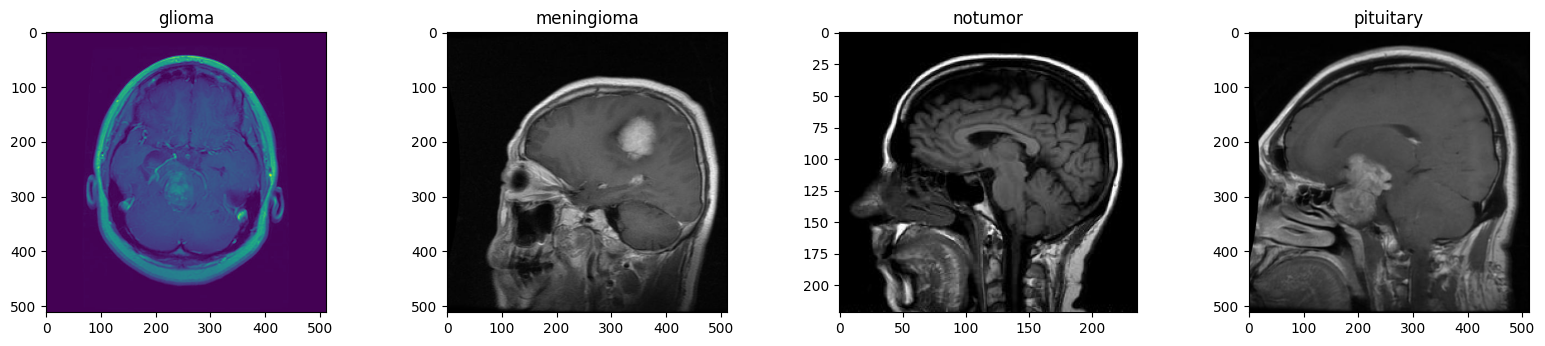

In [10]:
Plot_Classes(train_path)

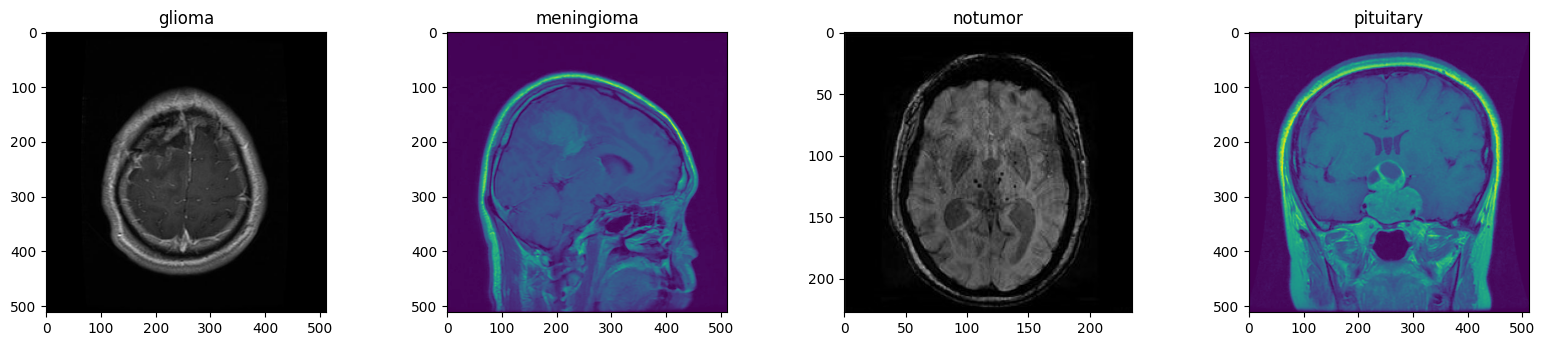

In [11]:
Plot_Classes(test_path)

In [12]:
train_data['Label'].value_counts()

Label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

In [13]:
px.histogram(train_data, y="Label", color="Label", title="Classes Distribution")

In [14]:
test_data['Label'].value_counts()

Label
notumor       405
meningioma    306
glioma        300
pituitary     300
Name: count, dtype: int64

In [15]:
px.histogram(test_data, y="Label", color="Label", title="Classes Distribution")

In [16]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [17]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.15, 
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

# Creating training data generator
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training',  
                                                    seed=0)

# Creating validation data generator
val_generator = val_datagen.flow_from_directory(train_path,
                                                target_size=image_size,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='validation', 
                                                seed=0)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=0)

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [18]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """

    # Generate augmented samples
    # Use __next__() instead of next()
    augmented_samples = train_generator.__next__()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_ImageDataGenerator.pdf')

    plt.show()

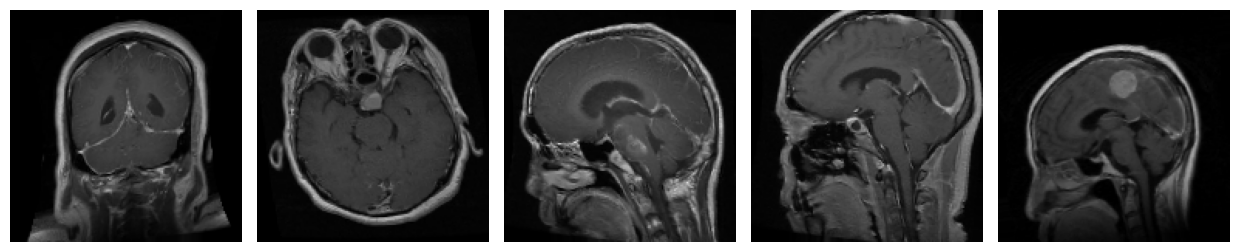

In [19]:
show_ImageDataGenerator(train_datagen, num_samples=5, figsize=(12.5, 8), save=False)

In [20]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)


print(f'Image shape: {image_shape}')
print(f'Batch size: {batch_size}')
print(f'Number of Train batches: {len(train_generator)}')
print(f'Number of Validation batches: {len(val_generator)}')
print(f'Number of Testing batches: {len(test_generator)}')

Image shape: (150, 150, 3)
Batch size: 32
Number of Train batches: 152
Number of Validation batches: 27
Number of Testing batches: 41


In [21]:
Classes_Map = train_generator.class_indices

num_classes = len(Classes_Map)

print("Number of Classes:", num_classes)
Classes_Map

Number of Classes: 4


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [22]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))
    plt.style.use('ggplot')


    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-' , label = "TrainL oss")
    plt.plot(epochs, val_loss, 'o-' , color='orange', label = "Val Loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-' , label = "Train Acc")
    plt.plot(epochs, val_accuracy, 'o-' , color='orange' , label = "Val Acc")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.style.use('default')

In [23]:
def CM(model, test_generator, categories):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    print(f"Classification Report for {model}:")
    print(classification_report(true_categories, predicted_categories, target_names=categories))

    return confusion_matrix_array


def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")

    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")

In [24]:
def create_cnn_model(input_shape=image_shape, num_classes=num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,660 (13.18 MB)

 Trainable params: 3,454,660 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
cnn_history = cnn_model.fit(train_generator,epochs=30,validation_data=val_generator)

Epoch 1/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 27s 172ms/step - accuracy: 0.5263 - loss: 1.0149 - val_accuracy: 0.7474 - val_loss: 0.6881
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step - accuracy: 0.8067 - loss: 0.4727 - val_accuracy: 0.7637 - val_loss: 0.6452
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step - accuracy: 0.8247 - loss: 0.4319 - val_accuracy: 0.7789 - val_loss: 0.6861
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step - accuracy: 0.8715 - loss: 0.3359 - val_accuracy: 0.8281 - val_loss: 0.4741
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 26s 170ms/step - accuracy: 0.8940 - loss: 0.2782 - val_accuracy: 0.8737 - val_loss: 0.3530
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 26s 171ms/step - accuracy: 0.9084 - loss: 0.2451 - val_accuracy: 0.9018 - val_loss: 0.3190
Epoch 7/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 48s 316ms/step - accuracy: 0.9275 - loss: 0.1850 - val_accuracy: 0.9006 - val_loss: 0.3376
Epoch 8/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 34s 224ms/step - accuracy: 0.9438 - loss: 0

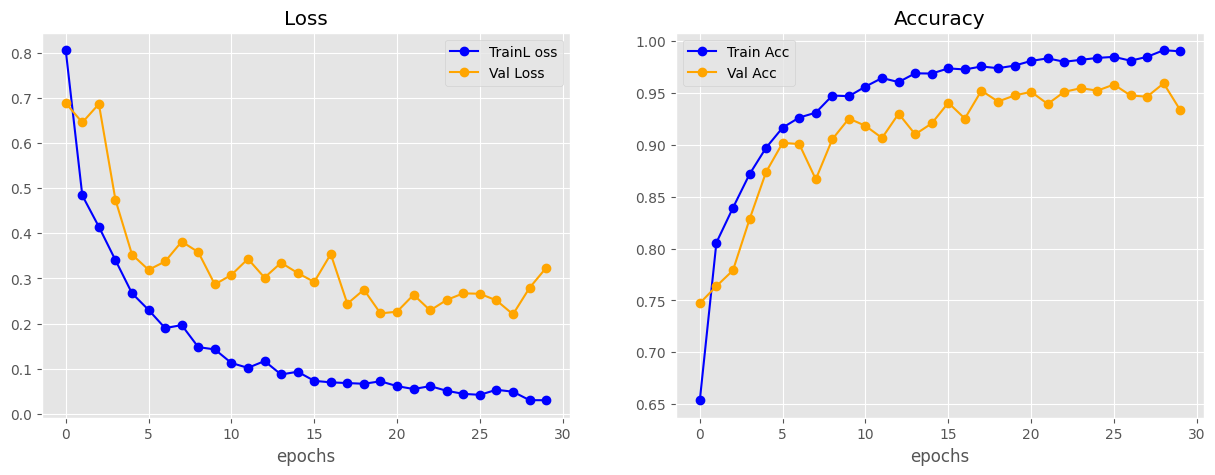

In [26]:
plot_curves(cnn_history)

In [27]:
loss, accuracy = cnn_model.evaluate(test_generator)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 298ms/step - accuracy: 0.9180 - loss: 0.4097
Test Loss: 0.27418
Test Accuracy: 0.94508


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
Classification Report for <Sequential name=sequential, built=True>:
              precision    recall  f1-score   support

      glioma       0.99      0.91      0.95       300
  meningioma       0.94      0.86      0.90       306
     notumor       0.95      1.00      0.97       405
   pituitary       0.91      1.00      0.95       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.95      0.94      1311



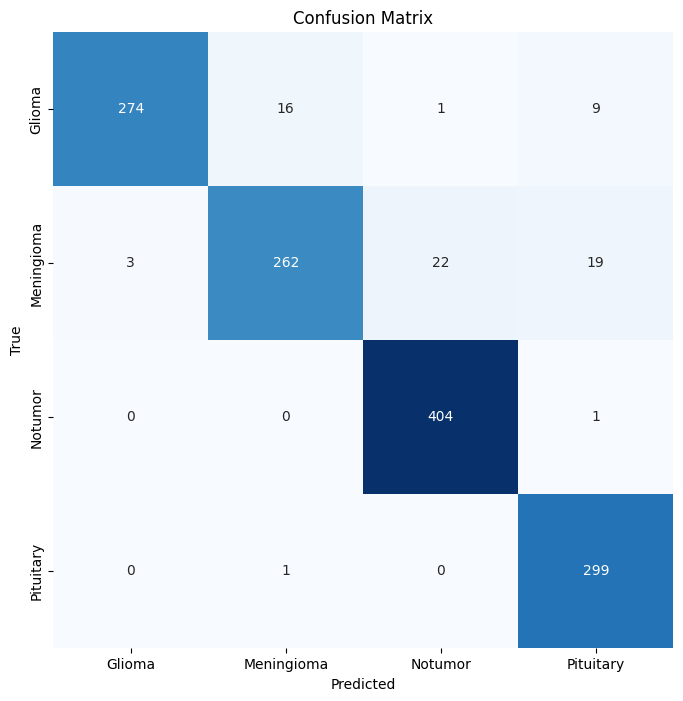

In [28]:
# Plotting confusion matrix
confusion_matrix = CM(model=cnn_model, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()

{'glioma': 0.0, 'meningioma': 0.0, 'notumor': 100.0, 'pituitary': 0.0}
{'glioma': 0.08, 'meningioma': 0.124, 'notumor': 99.795, 'pituitary': 0.001}
{'glioma': 0.0, 'meningioma': 0.0, 'notumor': 100.0, 'pituitary': 0.0}
{'glioma': 0.0, 'meningioma': 0.001, 'notumor': 99.999, 'pituitary': 0.0}
{'glioma': 0.0, 'meningioma': 0.0, 'notumor': 100.0, 'pituitary': 0.0}
{'glioma': 0.0, 'meningioma': 0.0, 'notumor': 100.0, 'pituitary': 0.0}
{'glioma': 0.0, 'meningioma': 0.001, 'notumor': 99.999, 'pituitary': 0.0}
{'glioma': 0.08, 'meningioma': 0.124, 'notumor': 99.795, 'pituitary': 0.001}
{'glioma': 0.0, 'meningioma': 0.0, 'notumor': 100.0, 'pituitary': 0.0}
{'glioma': 0.0, 'meningioma': 0.0, 'notumor': 100.0, 'pituitary': 0.0}


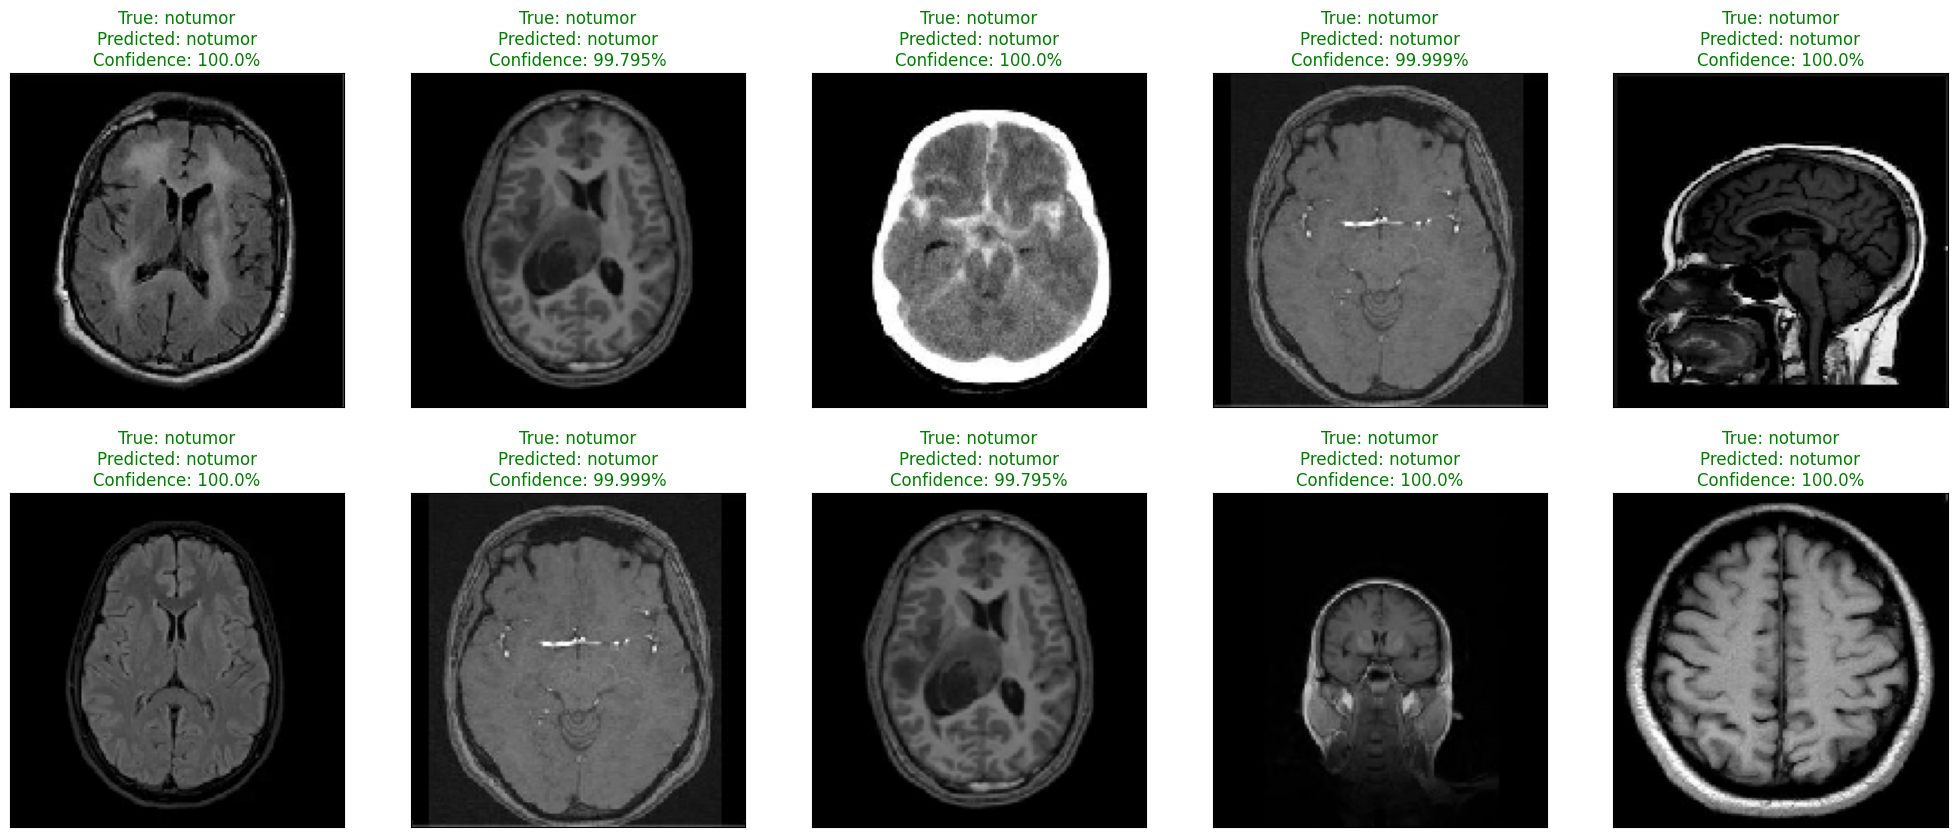

<Figure size 640x480 with 0 Axes>

In [29]:
# Display 10 random pictures predictions from the dataset with their labels

# Randomly select a batch and image indices for visualization
Random_batch = np.random.randint(0, len(test_generator))
Random_Img_Index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

# Iterate through 10 random images and make predictionszz
for i, ax in enumerate(axes.flat):
    # Select a random image and its true label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    # Get predictions from the CNN model
    Model_Predictions = cnn_model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0)
    Model_Highest_Prediction = np.argmax(Model_Predictions)

    # Map classes to prediction confidence scores
    Model_Predictions_Map = {c: round(p * 100, 3) for c, p in zip(classes, Model_Predictions.tolist()[0])}

    # Display the image and add title with true and predicted class
    ax.imshow(Random_Img)
    Pred_Class = classes[Model_Highest_Prediction]

    # Color the title green for correct, red for incorrect prediction
    color = "green" if classes[Random_Img_Label] == Pred_Class else "red"
    ax.set_title(f"True: {classes[Random_Img_Label]}\nPredicted: {Pred_Class}\nConfidence: {Model_Predictions_Map[Pred_Class]}%",
                 color=color)

    print(Model_Predictions_Map)

plt.show()
plt.tight_layout()


{'glioma': 0.0, 'meningioma': 0.0, 'notumor': 0.214, 'pituitary': 99.785}
{'glioma': 0.148, 'meningioma': 0.039, 'notumor': 99.813, 'pituitary': 0.0}
{'glioma': 0.0, 'meningioma': 0.0, 'notumor': 100.0, 'pituitary': 0.0}
{'glioma': 0.0, 'meningioma': 0.0, 'notumor': 0.0, 'pituitary': 100.0}
{'glioma': 0.0, 'meningioma': 0.0, 'notumor': 100.0, 'pituitary': 0.0}
{'glioma': 0.0, 'meningioma': 0.033, 'notumor': 99.967, 'pituitary': 0.0}
{'glioma': 0.0, 'meningioma': 0.0, 'notumor': 0.0, 'pituitary': 100.0}
{'glioma': 0.0, 'meningioma': 100.0, 'notumor': 0.0, 'pituitary': 0.0}
{'glioma': 0.0, 'meningioma': 0.033, 'notumor': 99.967, 'pituitary': 0.0}
{'glioma': 0.0, 'meningioma': 0.0, 'notumor': 100.0, 'pituitary': 0.0}


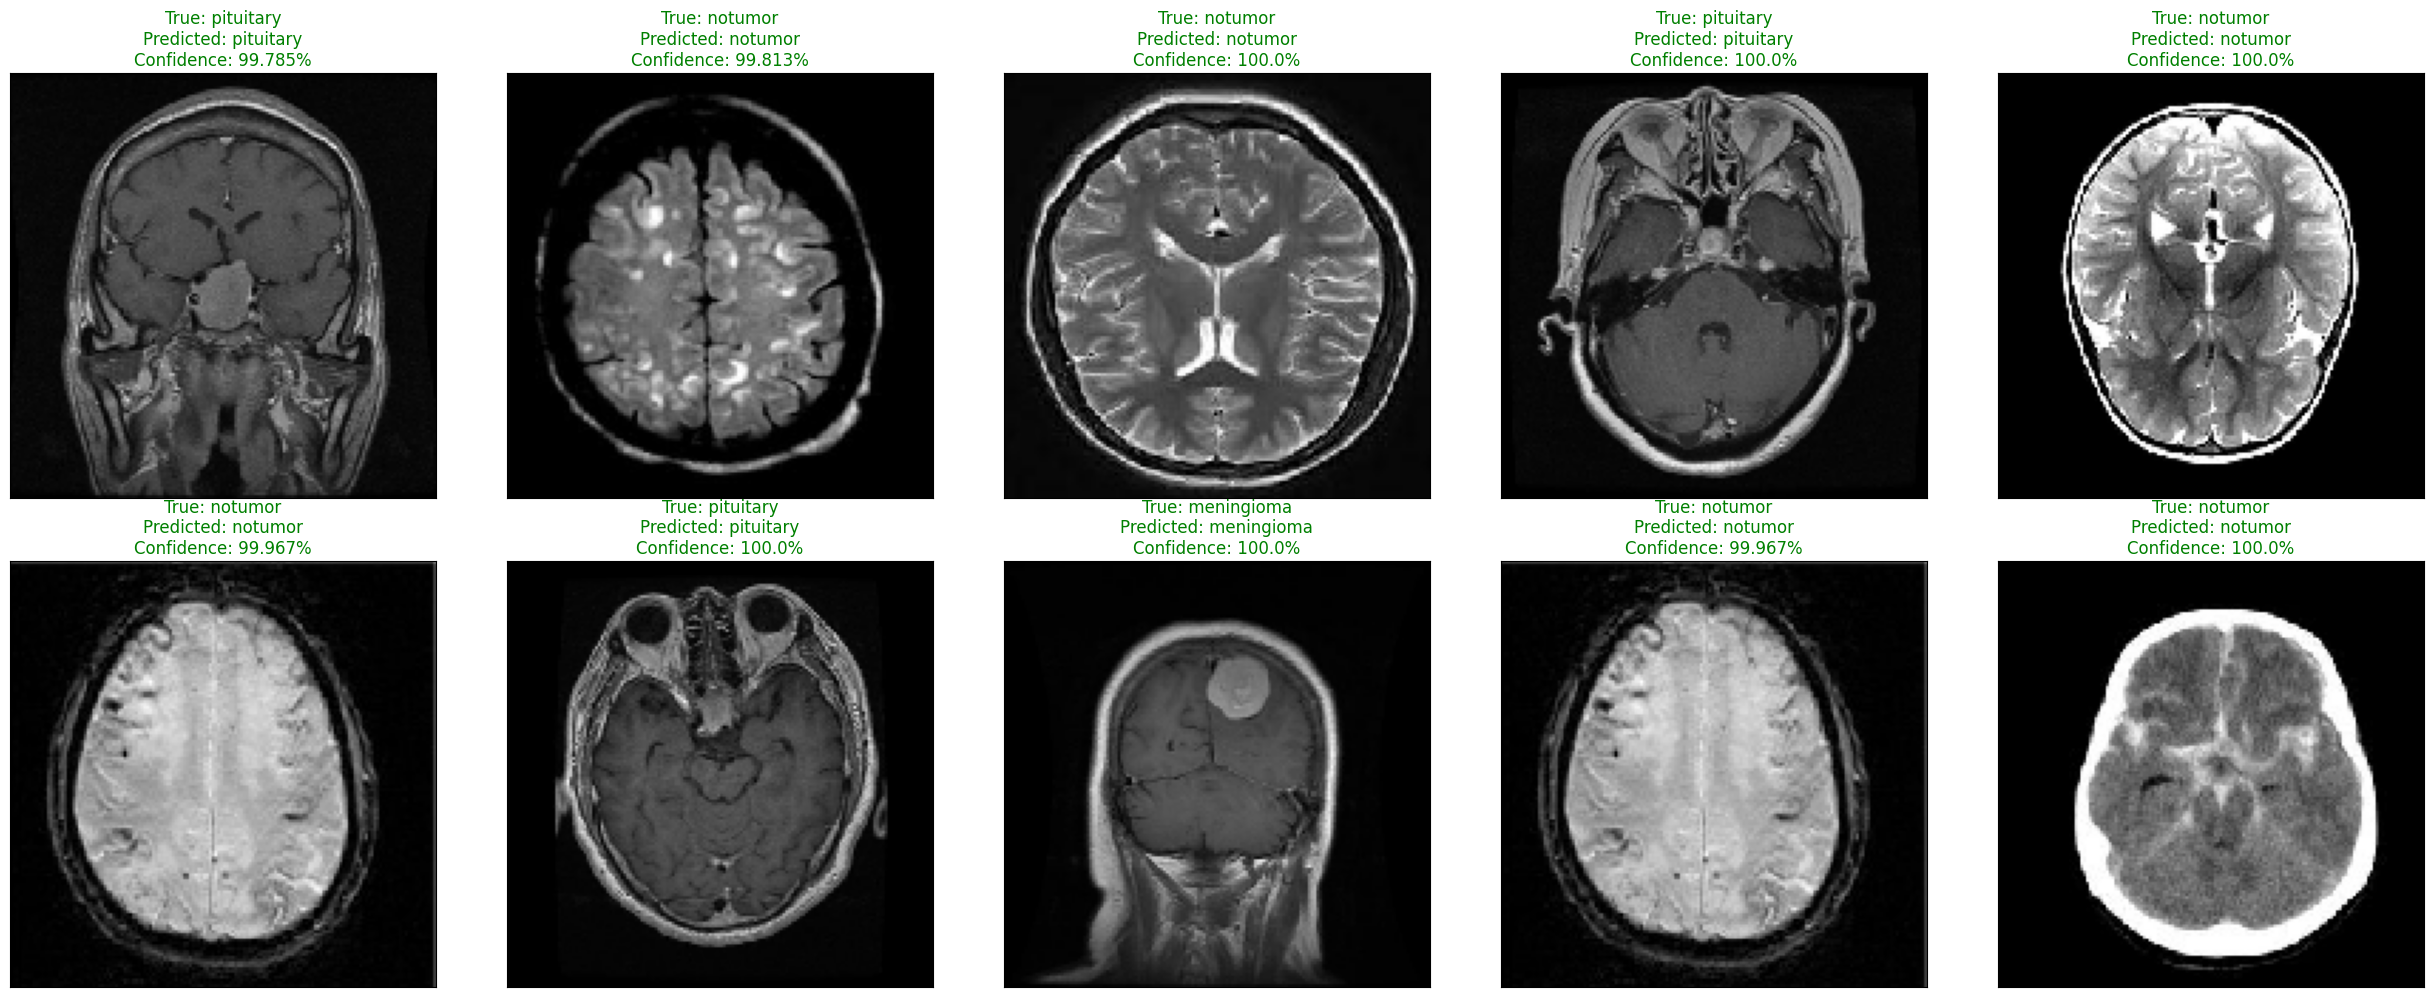

In [30]:
# Display 10 random pictures predictions from the dataset with their labels

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

# Loop to display 10 random images from random batches
for i, ax in enumerate(axes.flat):
    # Randomly select a batch index and an image index within that batch
    random_batch_index = np.random.randint(0, len(test_generator))
    random_img_index = np.random.randint(0, test_generator.batch_size)

    # Retrieve the batch and the specific image and label from it
    img_batch, label_batch = test_generator[random_batch_index]
    img = img_batch[random_img_index]
    true_label = np.argmax(label_batch[random_img_index])

    # Predict with the CNN model
    Model_Predictions = cnn_model.predict(tf.expand_dims(img, axis=0), verbose=0)
    Model_Highest_Prediction = np.argmax(Model_Predictions)

    # Map classes to prediction confidence scores
    Model_Predictions_Map = {c: round(p * 100, 3) for c, p in zip(classes, Model_Predictions.tolist()[0])}

    # Display the image and add title with true and predicted class
    ax.imshow(img)
    Pred_Class = classes[Model_Highest_Prediction]

    # Color the title green for correct, red for incorrect prediction
    color = "green" if classes[true_label] == Pred_Class else "red"
    ax.set_title(f"True: {classes[true_label]}\nPredicted: {Pred_Class}\nConfidence: {Model_Predictions_Map[Pred_Class]}%",
                 color=color)

    print(Model_Predictions_Map)

plt.tight_layout()
plt.show()


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_alexnet_model(input_shape=image_shape, num_classes=num_classes):
    model = Sequential()
    
    model.add(Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

alexnet_model = create_alexnet_model()
alexnet_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 35, 35, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 17, 17, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │     9,441,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,986,180 (114.39 MB)

 Trainable params: 29,986,180 (114.39 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from tensorflow.keras.layers import AveragePooling2D, concatenate, Input
from tensorflow.keras.models import Model

def inception_module(x, filters):
    # 1x1 convolution
    conv_1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 3x3 convolution
    conv_3x3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv_3x3)

    # 5x5 convolution
    conv_5x5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv_5x5)

    # Max pooling
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(pool_proj)

    # Concatenate filters
    x = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)
    return x

def create_googlenet_model(input_shape=image_shape, num_classes=num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

googlenet_model = create_googlenet_model()
googlenet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 75, 75,    │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 38, 38,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 38, 38,    │      6,240 │ max_pooling2d[0]… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 38, 38,    │      1,040 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 38, 38,    │          0 │ max_pooling2d[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 38, 38,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 38, 38,    │    110,720 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 38, 38,    │     12,832 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 38, 38,    │      2,080 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38, 38,    │          0 │ conv2d_1[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_3[0][0],   │
│                     │                   │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 38, 38,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 38, 38,    │      8,224 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 38, 38,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 38, 38,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 38, 38,    │    221,376 │ conv2d_8[0][0]    │
│                     │ 192)              │            │                 

 Total params: 177,979,124 (678.94 MB)

 Trainable params: 177,979,124 (678.94 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

def create_vgg16_model(input_shape=image_shape, num_classes=num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the convolutional base
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

vgg16_model = create_vgg16_model()
vgg16_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,396 (57.14 MB)

 Trainable params: 264,708 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [34]:
# Training AlexNet
alexnet_history = alexnet_model.fit(train_generator, epochs=30, validation_data=val_generator)


Epoch 1/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 40s 252ms/step - accuracy: 0.3096 - loss: 1.4626 - val_accuracy: 0.2327 - val_loss: 1.3971
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 251ms/step - accuracy: 0.3151 - loss: 1.3461 - val_accuracy: 0.4749 - val_loss: 1.1229
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 40s 259ms/step - accuracy: 0.5502 - loss: 0.9811 - val_accuracy: 0.5474 - val_loss: 1.0000
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 37s 240ms/step - accuracy: 0.6589 - loss: 0.7501 - val_accuracy: 0.6468 - val_loss: 0.9504
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 37s 241ms/step - accuracy: 0.7546 - loss: 0.6114 - val_accuracy: 0.7766 - val_loss: 0.7357
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 250ms/step - accuracy: 0.7899 - loss: 0.5340 - val_accuracy: 0.8082 - val_loss: 0.6238
Epoch 7/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 39s 253ms/step - accuracy: 0.8072 - loss: 0.4834 - val_accuracy: 0.7918 - val_loss: 0.5940
Epoch 8/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 39s 257ms/step - accuracy: 0.8270 - loss: 0

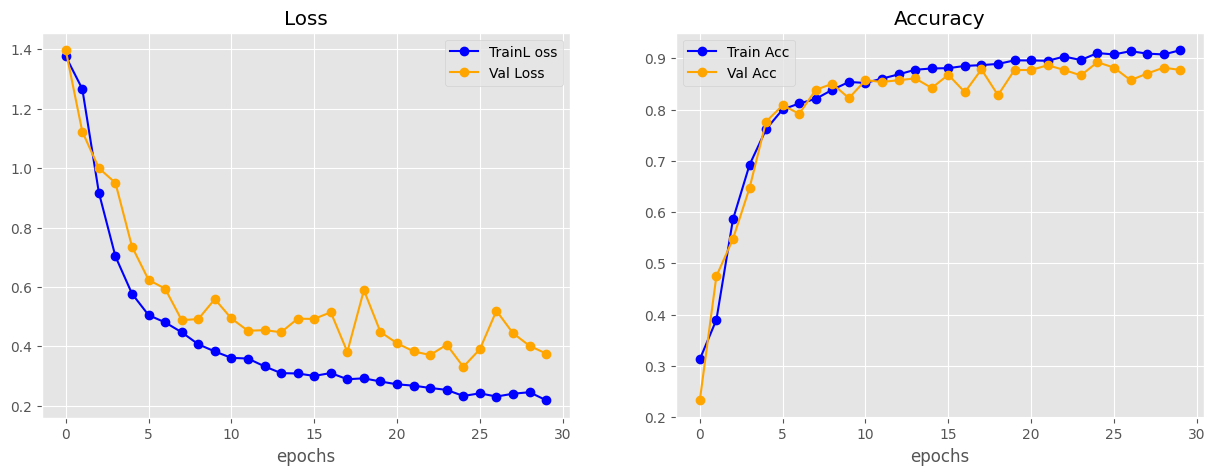

In [35]:
plot_curves(alexnet_history)

In [36]:
# Evaluate each model on the test set
alexnet_loss, alexnet_acc = alexnet_model.evaluate(test_generator)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7994 - loss: 0.5271


In [37]:

# Training GoogLeNet
googlenet_history = googlenet_model.fit(train_generator, epochs=30, validation_data=val_generator)


Epoch 1/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 129s 833ms/step - accuracy: 0.5724 - loss: 1.4895 - val_accuracy: 0.8023 - val_loss: 0.5925
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 127s 832ms/step - accuracy: 0.7970 - loss: 0.5316 - val_accuracy: 0.7977 - val_loss: 0.5921
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 127s 835ms/step - accuracy: 0.8278 - loss: 0.4225 - val_accuracy: 0.8187 - val_loss: 0.4983
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 128s 840ms/step - accuracy: 0.8614 - loss: 0.3808 - val_accuracy: 0.8281 - val_loss: 0.5052
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 127s 833ms/step - accuracy: 0.8807 - loss: 0.2986 - val_accuracy: 0.8538 - val_loss: 0.4221
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 127s 833ms/step - accuracy: 0.9042 - loss: 0.2585 - val_accuracy: 0.8737 - val_loss: 0.4011
Epoch 7/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 128s 838ms/step - accuracy: 0.9132 - loss: 0.2265 - val_accuracy: 0.8351 - val_loss: 0.4204
Epoch 8/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 127s 834ms/step - accuracy: 0.9222 -

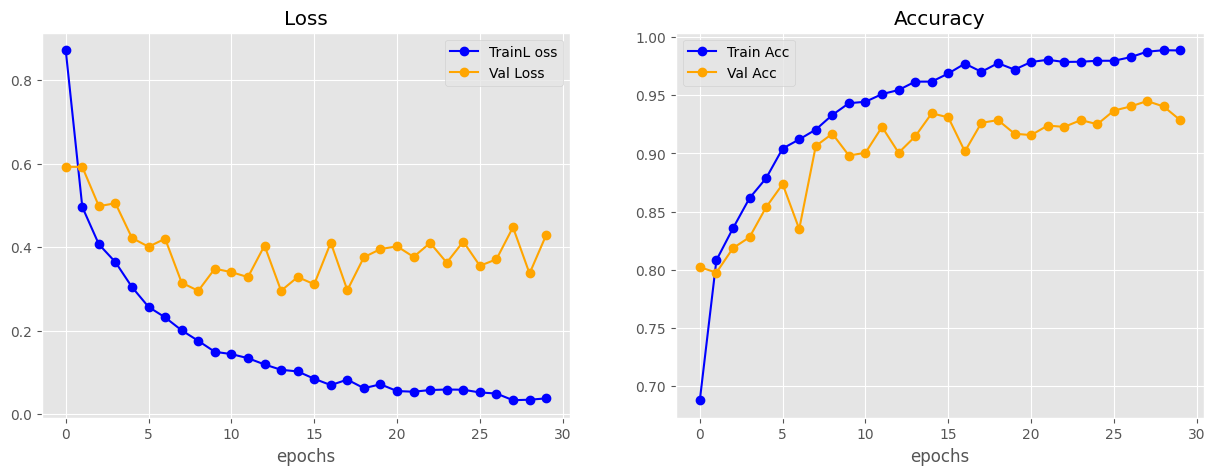

In [38]:
plot_curves(googlenet_history)

In [ ]:

googlenet_loss, googlenet_acc = googlenet_model.evaluate(test_generator)

41/41 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9257 - loss: 0.2736


: 

In [ ]:

# Training VGG16
vgg16_history = vgg16_model.fit(train_generator, epochs=30, validation_data=val_generator)


Epoch 1/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 114s 741ms/step - accuracy: 0.6491 - loss: 0.8912 - val_accuracy: 0.7193 - val_loss: 0.7284
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 114s 751ms/step - accuracy: 0.8604 - loss: 0.3996 - val_accuracy: 0.7895 - val_loss: 0.6133
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 114s 746ms/step - accuracy: 0.8758 - loss: 0.3425 - val_accuracy: 0.8058 - val_loss: 0.5357
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 116s 765ms/step - accuracy: 0.8873 - loss: 0.3167 - val_accuracy: 0.8327 - val_loss: 0.4716
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.9002 - loss: 0.2918 - val_accuracy: 0.8140 - val_loss: 0.5567
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.8937 - loss: 0.2849 - val_accuracy: 0.8433 - val_loss: 0.4396
Epoch 7/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.8994 - loss: 0.2726 - val_accuracy: 0.8561 - val_loss: 0.4590
Epoch 8/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - accuracy: 0.9062 - loss: 0.255

In [ ]:
plot_curves(vgg16_history)

In [ ]:
vgg16_loss, vgg16_acc = vgg16_model.evaluate(test_generator)

In [ ]:
# Plot training curves
print(f"AlexNet Test Accuracy: {alexnet_acc:.3f}")
print(f"GoogLeNet Test Accuracy: {googlenet_acc:.3f}")
print(f"VGG16 Test Accuracy: {vgg16_acc:.3f}")
